# Introduction

- Goal

이번 목표는 세포핵 탐지를 자동화하는 것이다. 심장 질환, 만성 질환, 알츠하이머 등 많은 사람들이 질병을 통해 목숨을 잃는다. 세포핵 탐지를 자동화하면, 희귀 질병부터 감기에 이르기까지 치료의 속도를 높일 수 있다. 

- Why nuclei?

DNA가 들어있는 세포핵을 확인하는 것이 대부분의 분석의 시작점이다.  핵 식별은 표본에서 각각의 개별 세포를 식별할 수 있게 해준다. 
핵 탐지 과정을 자동화하여 효율적인 약물 검사가 가능해진다. 


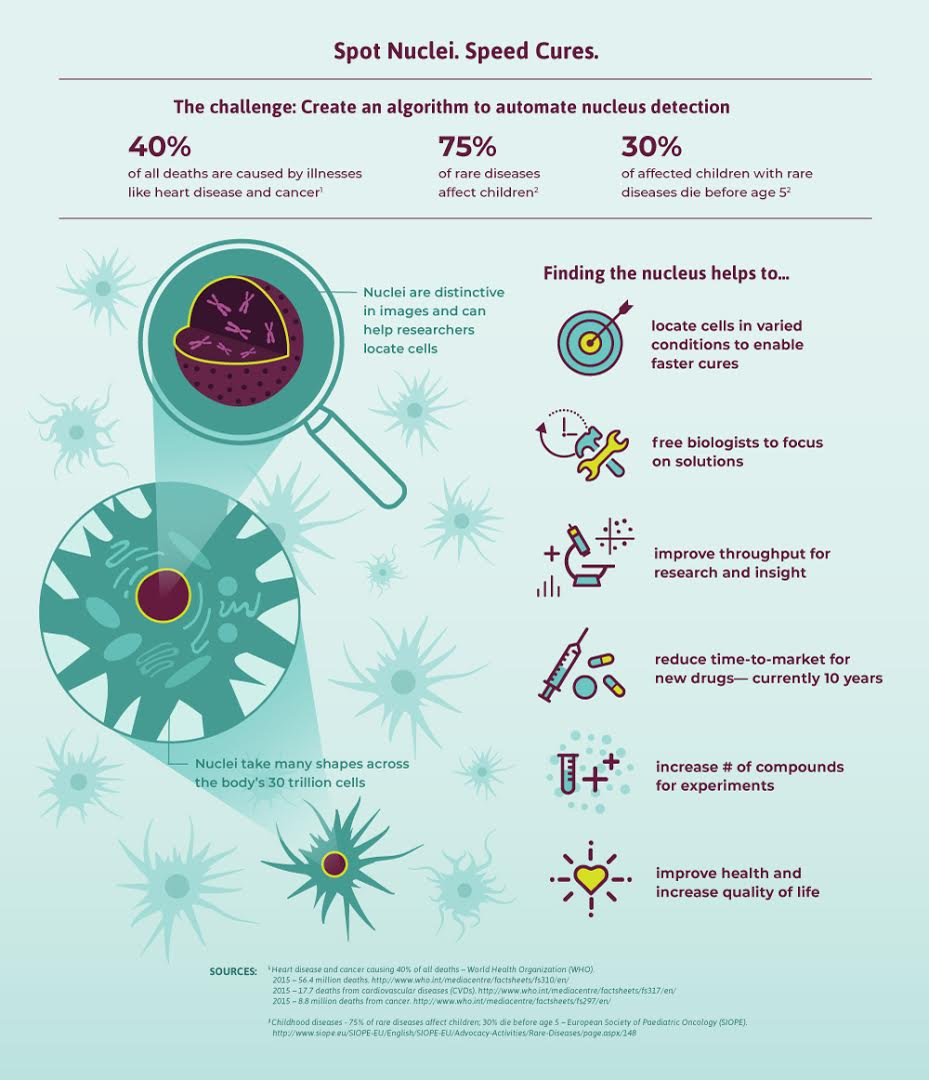

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juseongml","key":"8a9790b425140dd45cb603d44ae5cc50"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 5.58MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 89.0MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 97.7MB/s]
 92% 73.0M/79.1M [00:00<00:00, 66.7MB/s]
100% 79.1M/79.1M [00:00<00:00, 116MB/s] 
 90% 249M/276M [00:04<00:00, 59.3MB/s]
100% 276M/276M [00:04<00:00, 60.0MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 102MB/s]
 55% 5.00M/9.10M [00:00<00:00, 32.8MB/s]
100% 9.10M/9.10M [00:00<00:00, 44.5MB/s]


In [4]:
! ls

kaggle.json			  stage1_train_labels.csv.zip
sample_data			  stage1_train.zip
stage1_sample_submission.csv.zip  stage2_sample_submission_final.csv.zip
stage1_solution.csv.zip		  stage2_test_final.zip
stage1_test.zip


## Import important libraries

In [20]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import keras

### Getting Data

In [6]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "stage1_train.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
     
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("stage1_train") 
    print('Done!') 

Extracting all the files now...
Done!


In [7]:
# specifying the zip file name 
file_name = "stage1_test.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
     
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("stage1_test") 
    print('Done!') 

Extracting all the files now...
Done!


## Resizing image 

In [8]:
TRAIN_PATH="stage1_train/"
TEST_PATH='stage1_test/'

In [9]:
train_ids=next(os.walk(TRAIN_PATH))[1] #path의 폴더들을 리턴한다.
test_ids=next(os.walk(TEST_PATH))[1]

In [17]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

In [11]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [12]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask

  

  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 670/670 [06:25<00:00,  1.74it/s]


In [13]:
#test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = img

print('Done!')

  8%|▊         | 5/65 [00:00<00:01, 39.09it/s]

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 34.70it/s]

Done!


Having a look at training images and segmented images related to it

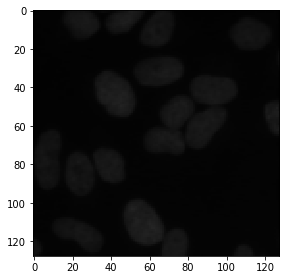

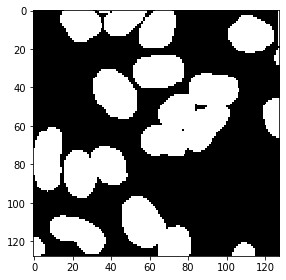

In [14]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))

plt.show()

In [15]:
seed = 42
np.random.seed = seed

# Building U-Net

자세한 설명은 블로그에서 리뷰를 했으니 넘어간다.https://juseong-tech.tistory.com/2
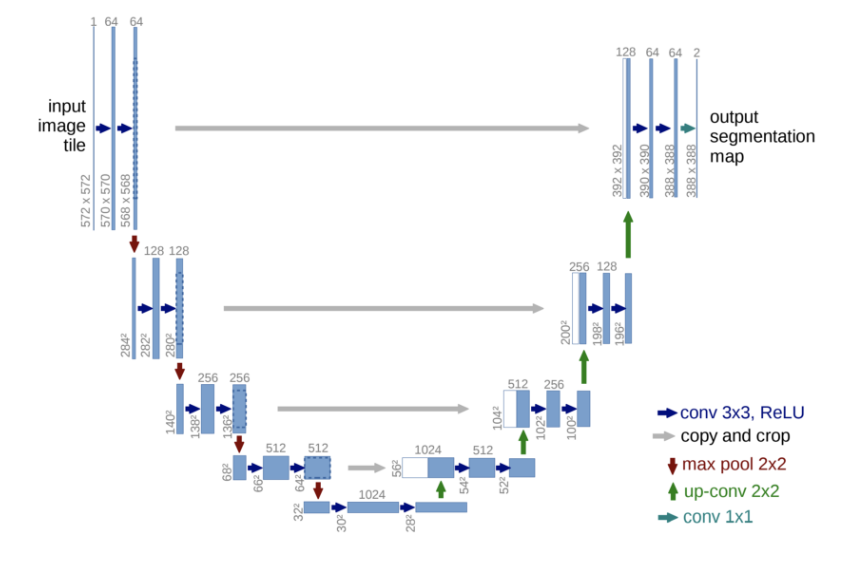

In [33]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x : x /255)(inputs)

#contracting path
cont1 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#활성화 함수로 relu를 사용했으므로 He를 사용한다. 
cont1 = keras.layers.Dropout(0.1)(cont1)
cont1 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(cont1)
pool1 = keras.layers.MaxPooling2D((2,2))(cont1)

cont2 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
cont2 = keras.layers.Dropout(0.1)(cont2)
cont2 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(cont2)
pool2 = keras.layers.MaxPooling2D((2,2))(cont2)

cont3 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
cont3 = keras.layers.Dropout(0.2)(cont3)
cont3 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(cont3)
pool3 = keras.layers.MaxPooling2D((2,2))(cont3)

cont4 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
cont4 = keras.layers.Dropout(0.2)(cont4)
cont4 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(cont4)
pool4 = keras.layers.MaxPooling2D((2,2))(cont4)

#논문보다 한 층을 추가한다. 
cont5 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
cont5 = keras.layers.Dropout(0.2)(cont5)
cont5 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(cont5)


#Expansive path
exp1 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(cont5)
exp1 = keras.layers.concatenate([exp1, cont4])
exp1 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(exp1)
exp1 = keras.layers.Dropout(0.2)(exp1)
exp1 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(exp1)

exp2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(exp1)
exp2 = tf.keras.layers.concatenate([exp2, cont3])
exp2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(exp2)
exp2 = tf.keras.layers.Dropout(0.2)(exp2)
exp2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(exp2)

exp3 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(exp2)
exp3 = tf.keras.layers.concatenate([exp3, cont2])
exp3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(exp3)
exp3 = tf.keras.layers.Dropout(0.1)(exp3)
exp3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(exp3)

exp4 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(exp3)
exp4 = tf.keras.layers.concatenate([exp4, cont1], axis=3)
exp4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(exp4)
exp4 = tf.keras.layers.Dropout(0.1)(exp4)
exp4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(exp4)

outputs = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(exp4)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#양성,음성을 구분하는것이기 때문에 binary_crossentropy를 사용한다. 

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 128, 128, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 128, 128, 16) 448         lambda_13[0][0]                  
__________________________________________________________________________________________________
dropout_68 (Dropout)            (None, 128, 128, 16) 0           conv2d_135[0][0]                 
_______________________________________________________________________________________

In [40]:
#callbacks
callbacks=[keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
           keras.callbacks.TensorBoard(log_dir='logs')]

### Training Model

In [41]:
result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=callbacks)

Epoch 1/50
 1/38 [..............................] - ETA: 0s - loss: 0.7558 - accuracy: 0.2722WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - 2s 61ms/step - loss: 0.5125 - accuracy: 0.7760 - val_loss: 0.2853 - val_accuracy: 0.8346
Epoch 2/50
38/38 [==============================] - 1s 37ms/step - loss: 0.2652 - accuracy: 0.8404 - val_loss: 0.2143 - val_accuracy: 0.9140
Epoch 3/50
38/38 [==============================] - 1s 36ms/step - loss: 0.1924 - accuracy: 0.9283 - val_loss: 0.1344 - val_accuracy: 0.9533
Epoch 4/50
38/38 [==============================] - 1s 36ms/step - loss: 0.1467 - accuracy: 0.9462 - val_loss: 0.1374 - val_accuracy: 0.9484
Epoch 5/50
38/38 [==============================] - 1s 36ms/step - loss: 0.1

- val_loss : 0.0718, val_accuracy : 0.9772 가 나왔다. 97.72%로 굉장히 정확한 수치를 보여준다. 테스트를 해보자.

## Testing Model

In [43]:
model_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 0s 49ms/step


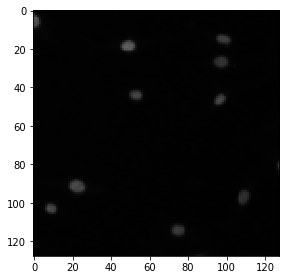

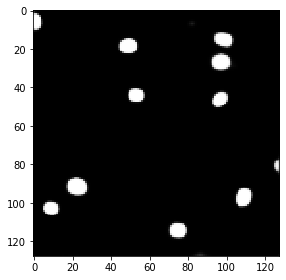

In [45]:
imshow(X_test[1])
plt.show()
imshow(np.squeeze(model_test[1]))
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


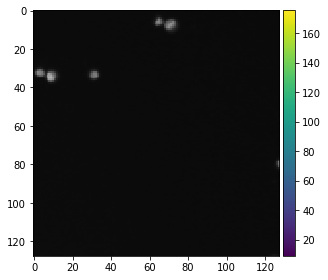

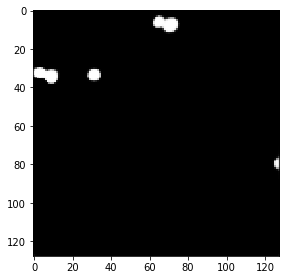

In [46]:
imshow(X_test[2])
plt.show()
imshow(np.squeeze(model_test[2]))
plt.show()

Test Data와 모델이 예측하는 Data가 거의 일치하게 나왔다. 모델 학습이 아주 잘된거 같다. 

처음 목표인 세포핵을 자동으로 찾아내는 알고리즘에 잘 도달했다. 

U - Net이 아주 효과가 좋았다. Medical Image에 있어서 사용하기 좋은 것 같다.